# Differential expression analysis
This notebook performs differential expression analysis using the real template experiment and simulated experiments, as a null set. 

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
num_runs = params['num_simulated']
project_id = params['project_id']
col_to_rank = params['col_to_rank']

rerun_template = True
rerun_simulated = True

In [4]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    project_id+"_groups.tsv")

## Install R libraries

In [5]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")
#BiocManager::install('EnhancedVolcano')
#devtools::install_github('kevinblighe/EnhancedVolcano')

NULL


In [6]:
%%R
library('limma')

### Get differentially expressed genes from template experiment

In [7]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir -i rerun_template

source('../functions/DE_analysis.R')

out_file <- paste(local_dir,
                  "DE_stats/DE_stats_template_data_",
                  project_id,
                  "_real.txt",
                  sep="")

if (rerun_template){
    get_DE_stats(metadata_file,
                 project_id, 
                 template_data_file,
                 "template",
                 local_dir,
                 "real")
    }

[1] 2361


### Check signal strength

In [8]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

In [9]:
template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

template_DEGs = template_DE_stats[(template_DE_stats['adj.P.Val']<0.001) & 
                                  (template_DE_stats['logFC'].abs()>1)]
print(template_DEGs.shape)
template_DEGs.head(10)

(2361, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
SNRK.AS1,-4.958371,5.900715,-21.028847,2.615538e-16,3.049023e-12,26.905199
ITIH5,-3.703407,3.134390,-20.765642,3.428180e-16,3.049023e-12,26.662724
HYOU1,15.428655,22.573867,17.943977,7.697954e-15,4.564373e-11,23.820691
GATA6,-10.775702,9.814635,-17.441516,1.401198e-14,5.823299e-11,23.263321
KIAA0040,-16.443337,16.758748,-17.144691,2.010212e-14,5.823299e-11,22.926022
PXDC1,-20.778738,22.482341,-17.103739,2.113736e-14,5.823299e-11,22.879006
ITGA8,-7.371572,6.564904,-17.038028,2.291606e-14,5.823299e-11,22.803318
SH3BP5.AS1,-14.343534,17.211195,-16.571631,4.098182e-14,9.112307e-11,22.257258
STX11,-23.845923,16.245391,-16.457504,4.734689e-14,9.357849e-11,22.121231
STX2,-4.236599,6.620074,-16.277501,5.955825e-14,1.059422e-10,21.904717


In [10]:
%%R
library(EnhancedVolcano)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggrepel

  warnings.warn(x, RRuntimeWarning)


In [11]:
%%R -i project_id -i template_DE_stats_file -i local_dir

source('../functions/DE_analysis.R')

create_volcano(template_DE_stats_file,
               project_id,
               "adj.P.Val",
               local_dir)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


### Get differentially expressed genes from each simulated experiment

In [12]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -i rerun_simulated -o num_sign_DEGs_simulated

source('../functions/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    out_file <- paste(local_dir, 
                      "DE_stats/DE_stats_simulated_data_",
                      project_id,
                      "_",
                      i,
                      ".txt", 
                      sep="")
    
    if (rerun_simulated){
        run_output <- get_DE_stats(metadata_file,
                                   project_id, 
                                   simulated_data_file,
                                   "simulated",
                                   local_dir,
                                   i)
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
    } else {
        # Read in DE stats data
        DE_stats_data <- as.data.frame(read.table(out_file, sep="\t", header=TRUE, row.names=1))
        
        # Get number of genes that exceed threshold
        threshold <- 0.001
        sign_DEGs <- DE_stats_data[DE_stats_data[,'adj.P.Val']<threshold & abs(DE_stats_data[,'logFC'])>1,]
        
        num_sign_DEGs <- nrow(sign_DEGs)
        
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, num_sign_DEGs)
    }
}

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


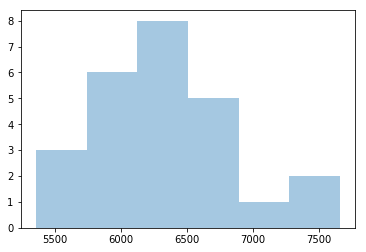

In [13]:
# Plot distribution of differentially expressed genes for simulated experiments
sns.distplot(num_sign_DEGs_simulated,
            kde=False)

**Check**

As a check, we compared the number of DEGs identified here versus what was reported in the [Kim et. al. publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/#pone.0055596.s008), which found:
* Four conditions needed to be met for the genes to be selected as differentially expressed genes (DEGs): (i) overall differential expression from the edgeR analysis with FDR < 0.001, (ii) a minimum of 3 patients with significant differential expression, as tested by edgeR for individual differential expression with FDR < 0.01, (iii) consistent up/down regulation among different patients representing more than a two-fold change, and (iv) significant expression in at least 3 patients to remove genes with large fold changes within the noise expression level (FVKM>2 in either normal or tumor tissue). 
* In total, we selected 1459 genes (543 upregulated and 916 downregulated in tumors) differentially expressed in female NSCLC never-smoker patients
* Used edgeR to identify DEGs

By comparison:
* Our study found 2358 DEGs using limma and applying FDR < 0.001 
* Spot checking the genes identified with their list of DEGs from S2, we found the some of the same genes and FC direction was consistent. 
* Currently we are normalizing read counts [downloaded from recount2](https://bioconductor.org/packages/devel/bioc/vignettes/recount/inst/doc/recount-quickstart.html) using RPKM and piping that through limma to identify DEG (this is legacy code from when we expected microarray input instead of RNA-seq)

## Get statistics for differential expression analysis

In [14]:
# Get ranks of template experiment

# If ranking by p-value or adjusted p-value then high rank = low value
if col_to_rank in ['P.Value', 'adj.P.Val']:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].rank(ascending = False)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=True)

# If ranking by logFC then high rank = high abs(value)
elif col_to_rank in ['logFC','t']:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].abs().rank(ascending = True)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=False)

# If ranking by Z-score then high rank = high value
else:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].rank(ascending = True)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=False)

template_DE_stats.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking
IGHG1,4217.285092,2847.658556,2.673512,0.013707,0.034427,-3.801130,17787.0
SCGB3A1,2953.135576,1565.924672,2.016830,0.055778,0.107343,-5.077643,17785.0
CEACAM6,682.863735,420.210228,4.225483,0.000333,0.001748,-0.220385,17784.0
IGLL5,605.225857,482.844988,3.306012,0.003143,0.010616,-2.405372,17782.0
COL1A1,372.527241,283.027840,2.744314,0.011680,0.030352,-3.651605,17776.0


In [15]:
# Concatenate simulated experiments
simulated_DE_stats_all = pd.DataFrame()
for i in range(num_runs):
    simulated_DE_stats_file = os.path.join(
        local_dir, 
        "DE_stats",
        "DE_stats_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    #Read results
    simulated_DE_stats = pd.read_csv(
        simulated_DE_stats_file,
        header=0,
        sep='\t',
        index_col=0)
    
    simulated_DE_stats.reset_index(inplace=True)
    
    # Concatenate df
    simulated_DE_stats_all = pd.concat([simulated_DE_stats_all,
                                       simulated_DE_stats])
    
print(simulated_DE_stats_all.shape)
simulated_DE_stats_all.head()

(444700, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TRIM35,-2.016667,4.703667,-34.999181,3.901752e-21,6.940437e-17,38.176016
1,LTA4H,-3.896667,14.553917,-32.807522,1.629743e-20,9.826932e-17,36.847294
2,TNFRSF11A,-0.288417,0.555042,-32.782579,1.657342e-20,9.826932e-17,36.831579
3,PFKFB3,-14.952500,37.006000,-30.137188,1.058735e-19,4.708193e-16,35.082075
4,PIKFYVE,-1.214500,3.434000,-29.365074,1.873315e-19,6.664504e-16,34.538436


In [16]:
# Aggregate statistics across all simulated experiments
if col_to_rank == "adj.P.Val":
    simulated_DE_summary_stats = simulated_DE_stats_all.groupby(['index'])[[col_to_rank]].agg(
        ['median','mean', 'std','count']
    )
else:
    simulated_DE_summary_stats = simulated_DE_stats_all.groupby(['index'])[[col_to_rank, 'adj.P.Val']].agg({
        col_to_rank:['median','mean', 'std','count'],
        'adj.P.Val':['median']
    })
simulated_DE_summary_stats.head()

logFC                                   adj.P.Val
             median        mean         std count        median
index                                                          
A1BG       0.060000   -0.081357    0.451846    25  8.587820e-05
A1BG.AS1  -0.323583   -0.376567    0.391158    25  1.676071e-06
A1CF       0.055000    0.083267    0.101779    25  9.470620e-05
A2M      -85.819000 -130.269233  120.137495    25  5.236363e-07
A2M.AS1   -4.554667   -5.739490    4.877714    25  1.384512e-07

In [17]:
# Rank gene by median value of col_to_rank for simulated experiments

# If ranking by p-value or adjusted p-value then high rank = low value
if col_to_rank in ['P.Value', 'adj.P.Val']:
    simulated_DE_summary_stats['ranking'] = simulated_DE_summary_stats[(col_to_rank,'median')].rank(ascending = False)
    simulated_DE_summary_stats = simulated_DE_summary_stats.sort_values(by=(col_to_rank,'median'), ascending=True)

# If ranking by logFC then high rank = high abs(value)
elif col_to_rank in ['logFC','t']:
    simulated_DE_summary_stats['ranking'] = simulated_DE_summary_stats[(col_to_rank,'median')].abs().rank(ascending = True)
    simulated_DE_summary_stats = simulated_DE_summary_stats.sort_values(by=(col_to_rank,'median'), ascending=False)

# If ranking by Z-score then high rank = high value
else:
    simulated_DE_summary_stats['ranking'] = simulated_DE_summary_stats[(col_to_rank,'median')].rank(ascending = True)
    simulated_DE_summary_stats = simulated_DE_summary_stats.sort_values(by=(col_to_rank,'median'), ascending=False)

simulated_DE_summary_stats.head()

logFC                                    adj.P.Val  ranking
            median        mean          std count        median         
index                                                                   
MALAT1  256.054917  359.940327   290.954934    25  2.134698e-09  17786.0
PPBP    239.168500  503.881513  1089.083426    25  1.013808e-05  17784.0
KRT19   195.587583  199.522837   149.966664    25  3.438387e-07  17782.0
GAPDH   185.239417  189.205047   163.120132    25  9.478568e-05  17780.0
RPL8    155.647167  143.552437   109.268113    25  2.614326e-06  17779.0

In [18]:
simulated_DE_summary_stats.tail()

logFC                                   adj.P.Val  ranking
            median        mean         std count        median         
index                                                                  
HLA.E  -187.379417 -207.162417  155.209825    25  8.309853e-09  17781.0
VIM    -201.612583 -220.483950   98.272249    25  1.297218e-12  17783.0
SFTPC  -246.843417 -448.041840  583.653871    25  1.388896e-06  17785.0
SFTPA2 -335.211583 -761.684613  858.802667    25  3.809934e-07  17787.0
FTL    -426.074583 -451.662577  512.215482    25  2.877843e-05  17788.0

In [19]:
# Merge template statistics with simulated statistics
template_simulated_DE_stats = template_DE_stats.merge(simulated_DE_summary_stats, 
                                                     left_index=True,
                                                     right_index=True)
print(template_simulated_DE_stats.shape)
template_simulated_DE_stats.head()

(17788, 13)


/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking,"(logFC, median)","(logFC, mean)","(logFC, std)","(logFC, count)","(adj.P.Val, median)","(ranking, )"
IGHG1,4217.285092,2847.658556,2.673512,0.013707,0.034427,-3.801130,17787.0,77.218583,225.556627,455.835918,25,2.263936e-03,17760.0
SCGB3A1,2953.135576,1565.924672,2.016830,0.055778,0.107343,-5.077643,17785.0,60.007417,179.771280,439.042381,25,2.378065e-04,17747.0
CEACAM6,682.863735,420.210228,4.225483,0.000333,0.001748,-0.220385,17784.0,31.686167,61.567437,86.167604,25,4.131667e-03,17665.0
IGLL5,605.225857,482.844988,3.306012,0.003143,0.010616,-2.405372,17782.0,38.949667,81.396393,130.100198,25,4.579799e-05,17700.0
COL1A1,372.527241,283.027840,2.744314,0.011680,0.030352,-3.651605,17776.0,-49.383083,-70.924307,89.409997,25,2.435053e-07,17724.0


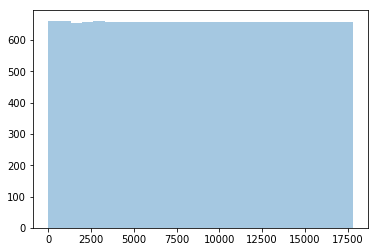

In [20]:
sns.distplot(template_simulated_DE_stats[('ranking',"")].values, kde=False)

In [21]:
# Parse columns
median_pval_simulated = template_simulated_DE_stats[('adj.P.Val','median')]
mean_test_simulated = template_simulated_DE_stats[(col_to_rank,'mean')]
std_test_simulated = template_simulated_DE_stats[(col_to_rank,'std')]
count_simulated = template_simulated_DE_stats[(col_to_rank,'count')]
rank_simulated = template_simulated_DE_stats[('ranking','')]

In [22]:
summary = pd.DataFrame(data={'Gene ID': template_simulated_DE_stats.index,
                             'Adj P-value (Real)': template_simulated_DE_stats['adj.P.Val'],
                             'Rank (Real)': template_simulated_DE_stats['ranking'],
                             'Test statistic (Real)': template_simulated_DE_stats[col_to_rank],
                             'Median adj p-value (simulated)': median_pval_simulated ,
                             'Rank (simulated)': rank_simulated ,
                             'Mean test statistic (simulated)': mean_test_simulated ,
                             'Std deviation (simulated)': std_test_simulated,
                             'Number of experiments (simulated)': count_simulated
                            }
                      )
summary['Z score'] = (summary['Test statistic (Real)'] - summary['Mean test statistic (simulated)'])/summary['Std deviation (simulated)']
summary.head()

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
IGHG1,IGHG1,0.034427,17787.0,4217.285092,2.263936e-03,17760.0,225.556627,455.835918,25,8.756941
SCGB3A1,SCGB3A1,0.107343,17785.0,2953.135576,2.378065e-04,17747.0,179.771280,439.042381,25,6.316849
CEACAM6,CEACAM6,0.001748,17784.0,682.863735,4.131667e-03,17665.0,61.567437,86.167604,25,7.210324
IGLL5,IGLL5,0.010616,17782.0,605.225857,4.579799e-05,17700.0,81.396393,130.100198,25,4.026354
COL1A1,COL1A1,0.030352,17776.0,372.527241,2.435053e-07,17724.0,-70.924307,89.409997,25,4.959754


In [23]:
# Save file
summary_file = os.path.join(
        local_dir, 
        "gene_summary_table_"+col_to_rank+".tsv")

summary.to_csv(summary_file, float_format='%.5f', sep='\t')